# pred-true 비교 그래프 그리기 노트북

이 노트북은  
1. **`pred_true_log.txt`** 같은 로그 텍스트 파일을 읽어  
2. 블록별로 **예측값(pred) vs. 실측값(true)** 곡선을 그립니다.

사용 방법
1. 이 노트북과 같은 폴더에 `pred_true_log.txt`(확장자 자유) 파일을 둡니다.  
2. 아래 코드 셀을 실행하면 블록별 그래프가 한꺼번에 표시됩니다.  

> 파일 이름을 바꾸고 싶다면 `FILENAME` 변수를 수정하세요.


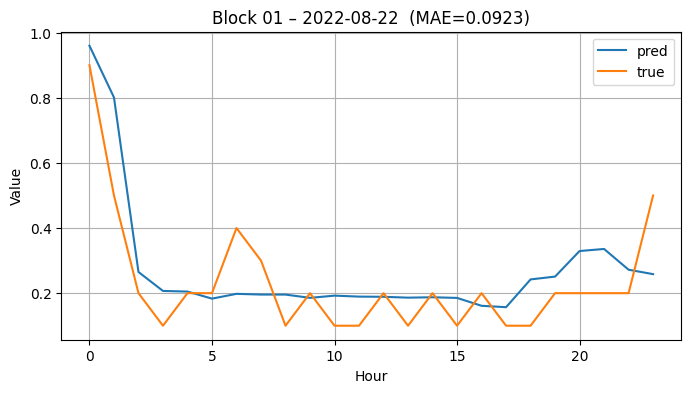

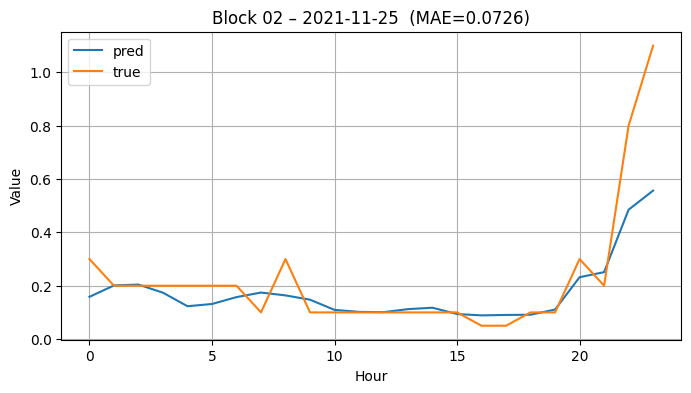

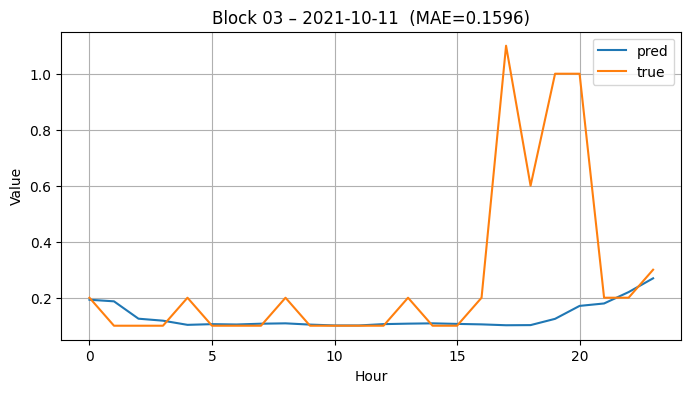

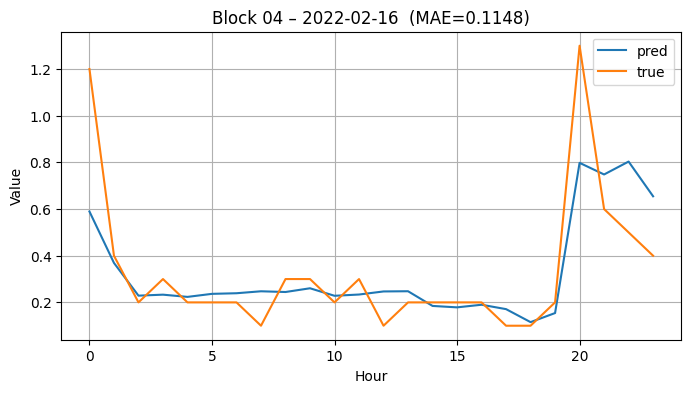

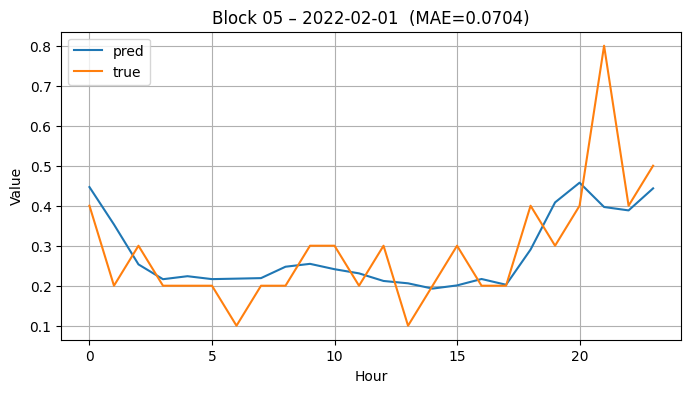

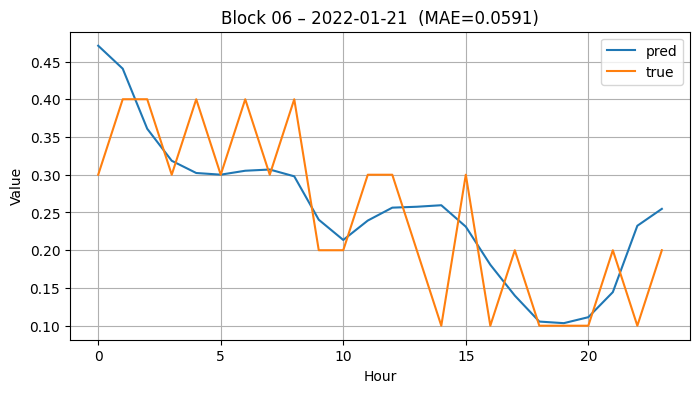

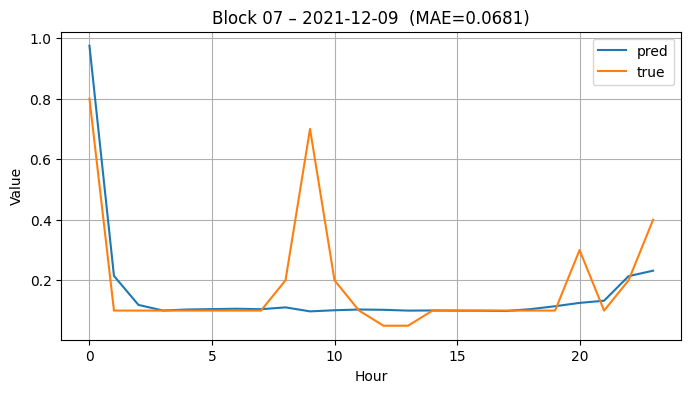

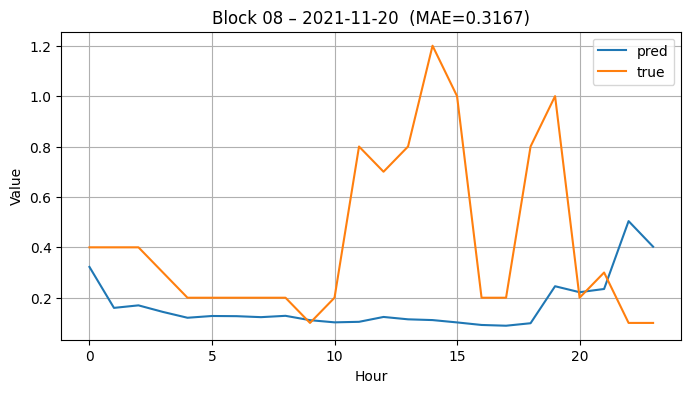

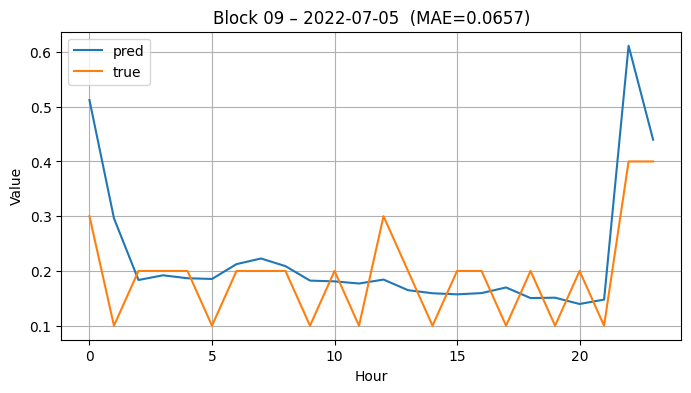

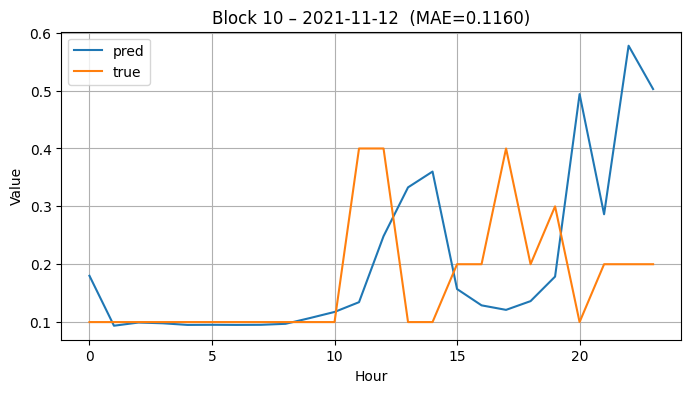

In [8]:
import re
import matplotlib.pyplot as plt
from pathlib import Path

# ▼ 여기서 텍스트 파일 이름을 지정하세요
FILENAME = "pred_true_log.txt"  # 같은 폴더에 있어야 함

assert Path(FILENAME).exists(), f"'{FILENAME}' 파일이 없습니다. 같은 폴더에 두고 실행하세요."

text = Path(FILENAME).read_text(encoding="utf-8")

# (1) 블록 헤더: [Block 01] 2022-08-01  MAE=0.2558
block_pat = re.compile(r"\[Block\s+(\d+)\]\s+(\d{4}-\d{2}-\d{2})\s+MAE=([0-9.]+)")
# (2) 한 줄: 2022-08-01 00:00  pred=0.4662 | true=0.6000 ...
line_pat = re.compile(r"(\d{4}-\d{2}-\d{2})\s+(\d{2}):\d{2}\s+pred=([0-9.]+)\s+\|\s+true=([0-9.]+)")

# 블록 위치 계산
blocks = []
for m in block_pat.finditer(text):
    blocks.append(
        {
            "num": int(m.group(1)),
            "date": m.group(2),
            "mae": float(m.group(3)),
            "start": m.end(),
        }
    )
for i in range(len(blocks)):
    blocks[i]["end"] = blocks[i + 1]["start"] if i < len(blocks) - 1 else len(text)

# 블록별 파싱·시각화
for b in blocks:
    segment = text[b["start"] : b["end"]]
    hours, preds, trues = [], [], []
    for m in line_pat.finditer(segment):
        hours.append(int(m.group(2)))
        preds.append(float(m.group(3)))
        trues.append(float(m.group(4)))

    if not hours:
        continue

    h, p, t = zip(*sorted(zip(hours, preds, trues), key=lambda x: x[0]))
    plt.figure(figsize=(8,4))
    plt.plot(h, p, label="pred")
    plt.plot(h, t, label="true")
    plt.title(f"Block {b['num']:02d} – {b['date']}  (MAE={b['mae']:.4f})")
    plt.xlabel("Hour")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
plt.show()


In [9]:
ERROR_TH  = 0.30
STABLE_TH = 0.05
outliers = []
import pandas as pd
import email2

events = pd.read_csv('led_data.csv', parse_dates=['timestamp'])
events['date'] = events['timestamp'].dt.date.astype(str)
events['hour'] = events['timestamp'].dt.hour
led_keys = set(zip(events['date'], events['hour']))

for b in blocks:
    seg  = text[b["start"]: b["end"]]
    rows = []
    for m in line_pat.finditer(seg):
        rows.append((
            int(m.group(2)),
            float(m.group(3)),
            float(m.group(4)),
        ))
    rows.sort(key=lambda x: x[0])

    for i in range(1, len(rows) - 1):
        h, p, t   = rows[i]
        _, _, t_p = rows[i - 1]
        _, _, t_n = rows[i + 1]

        err_big   = abs(p - t) > ERROR_TH
        stable    = (abs(t - t_p) < STABLE_TH) and (abs(t - t_n) < STABLE_TH)

        if err_big and stable:
            key = (b["date"], h)
            if key not in led_keys:
                outliers.append({
                    "block" : b["num"],
                    "date"  : b["date"],
                    "hour"  : h,
                    "true"  : t,
                    "pred"  : p,
                    "error" : round(abs(p - t), 4),
                })
                email2.send_email(b["date"] + " " + str(h) + "시 이상치가 탐지되었습니다.")

print(f"이상치 개수: {len(outliers)}개\\n")
for o in outliers:
    print(f"[Block {o['block']:02d}] {o['date']} {o['hour']:02d}:00  "
          f"true={o['true']:.4f}  pred={o['pred']:.4f}  |error|={o['error']}")


이메일이 성공적으로 전송되었습니다.
이상치 개수: 1개\n
[Block 10] 2021-11-12 22:00  true=0.2000  pred=0.5776  |error|=0.3776
